In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, silhouette_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Machine learning project/Online Retail.csv",encoding="latin-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


K-Means silhouette score: 0.6161
Agglomerative Clustering silhouette score: 0.6151
            Recency  Frequency  Monetary  KMeansCluster  AgglomerativeCluster
CustomerID                                                                   
12346.0         326          1  77183.60              0                     3
12347.0           2          7   4310.00              3                     1
12348.0          75          4   1797.24              3                     1
12349.0          19          1   1757.55              3                     1
12350.0         310          1    334.40              1                     2
LogisticRegression -> Accuracy: 0.9766, ROC AUC: 0.9978
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2781
           1       0.97      0.99      0.98      2780

    accuracy                           0.98      5561
   macro avg       0.98      0.98      0.98      5561
weighted avg       0.98      0.98      0.98

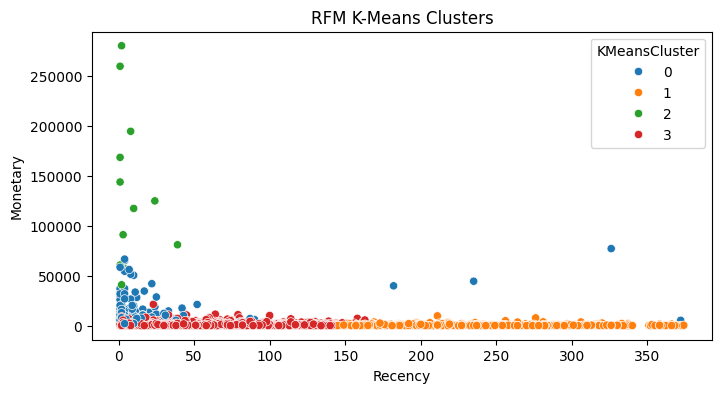

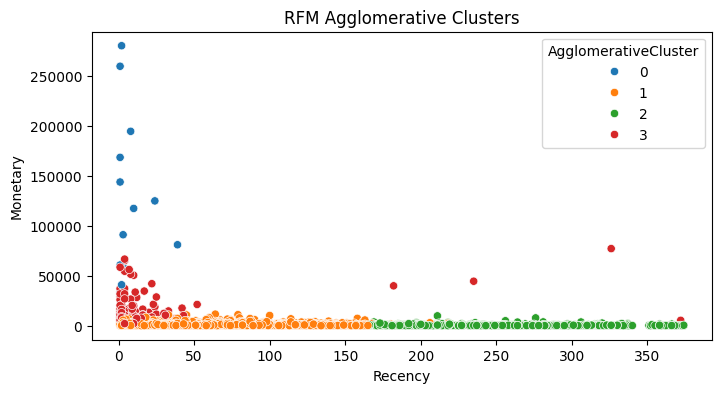

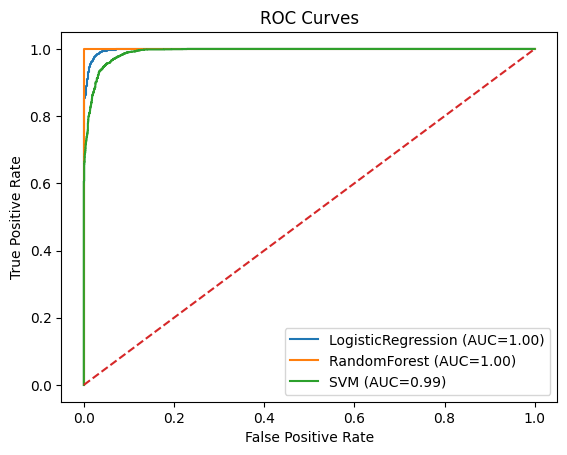

In [ ]:
# Data cleaning & feature creation
# Remove cancellations
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
# Drop missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M', dayfirst=True)
# Compute TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Clustering: RFM on Customer level
# Recency, Frequency, Monetary features
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm = rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})
# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)
sil_km = silhouette_score(rfm_scaled, rfm['KMeansCluster'])
print(f"K-Means silhouette score: {sil_km:.4f}")

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4)
rfm['AgglomerativeCluster'] = agg.fit_predict(rfm_scaled)
sil_agg = silhouette_score(rfm_scaled, rfm['AgglomerativeCluster'])
print(f"Agglomerative Clustering silhouette score: {sil_agg:.4f}")

# Display first few cluster assignments
print(rfm.head())

# Classification: Invoice-level high value prediction
# Feature engineering per Invoice
invoice_df = df.groupby('InvoiceNo').agg(
    Quantity=('Quantity','sum'),
    TotalPrice=('TotalPrice','sum'),
    DistinctItems=('StockCode','nunique')
)
# Add temporal features
invoice_dates = df.groupby('InvoiceNo')['InvoiceDate'].min()
invoice_df['Hour'] = invoice_dates.dt.hour
invoice_df['DayOfWeek'] = invoice_dates.dt.dayofweek

# Target: High vs Low value (> median)
median_value = invoice_df['TotalPrice'].median()
invoice_df['HighValue'] = (invoice_df['TotalPrice'] > median_value).astype(int)

# Prepare X, y
y = invoice_df['HighValue']
X = invoice_df.drop(columns=['HighValue'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler_cls = StandardScaler()
X_train_scaled = scaler_cls.fit_transform(X_train)
X_test_scaled = scaler_cls.transform(X_test)

# Classification Models & Evaluation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {'Accuracy': acc, 'ROC_AUC': auc}
    print(f"{name} -> Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Visualization
# Clustering RFM scatter plot
plt.figure(figsize=(8,4))
sns.scatterplot(
    x=rfm['Recency'], y=rfm['Monetary'],
    hue=rfm['KMeansCluster'], palette='tab10'
)
plt.title('RFM K-Means Clusters')
plt.show()

# Agglomerative cluster plot
plt.figure(figsize=(8,4))
sns.scatterplot(
    x=rfm['Recency'], y=rfm['Monetary'],
    hue=rfm['AgglomerativeCluster'], palette='tab10'
)
plt.title('RFM Agglomerative Clusters')
plt.show()

# ROC Curves
plt.figure()
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['ROC_AUC']:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()